# Regression Week 4: Ridge Regression (gradient descent)

In this notebook, you will implement ridge regression via gradient descent. You will:
* Convert an SFrame into a Numpy array
* Write a Numpy function to compute the derivative of the regression weights with respect to a single feature
* Write gradient descent function to compute the regression weights given an initial weight vector, step size, tolerance, and L2 penalty

# Fire up Turi Create

Make sure you have the latest version of Turi Create

In [ ]:
pip install turicreate

     |████████████████████████████████| 91.9MB 45kB/s 
     |████████████████████████████████| 2.1MB 41.7MB/s 
     |████████████████████████████████| 86.3MB 79kB/s 
     |████████████████████████████████| 20.2MB 1.3MB/s 
     |████████████████████████████████| 3.4MB 46.9MB/s 
     |████████████████████████████████| 3.8MB 32.2MB/s 
     |████████████████████████████████| 450kB 38.6MB/s 
ERROR: fastai 0.7.0 has requirement torch<0.4, but you'll have torch 1.4.0 which is incompatible.
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
  Found existing installation: Pillow 4.3.0
    Uninstalling Pillow-4.3.0:
      Successfully uninstalled Pillow-4.3.0
  Found existing installation: google-auth-oauthlib 0.4.0
    Uninstalling google-auth-oauthlib-0.4.0:
      Successfully uninstalled google-auth-oauthlib-0.4.0
  Found existing installation: tensorboard 2.1.0
    Uninstalling tensorboard-2.1.0:
      Successfully uninstalled tensor

In [ ]:
import turicreate

# 1. Load in house sales data

Dataset is from house sales in King County, the region where the city of Seattle, WA is located.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# sales = turicreate.SFrame('home_data.sframe/')
sales = turicreate.SFrame('/content/gdrive/My Drive/Turicreate/Week 8/home_data.sframe/')

If we want to do any "feature engineering" like creating new features or adjusting existing ones we should do this directly using the SFrames as seen in the first notebook of Week 2. For this notebook, however, we will work with the existing features.

# 2. Import useful functions from previous notebook

**3.** As in Week 2, we convert the SFrame into a 2D Numpy array. Copy and paste `get_numpy_data()` from the second notebook of Week 2.

In [ ]:
import numpy as np # note this allows us to refer to numpy as np instead 

In [ ]:
def get_numpy_data(data_sframe, features, output):
    data_sframe['constant'] = 1 # this is how you add a constant column to an SFrame
    # add the column 'constant' to the front of the features list so that we can extract it along with the others:
    features = ['constant'] + features # this is how you combine two lists

    # select the columns of data_SFrame given by the features list into the SFrame features_sframe (now including constant):
    features_sframe = data_sframe[features]

    # the following line will convert the features_SFrame into a numpy matrix:
    feature_matrix = features_sframe.to_numpy()

    # assign the column of data_sframe associated with the output to the SArray output_sarray
    output_sarray = data_sframe[output]

    # the following will convert the SArray into a numpy array by first converting it to a list
    output_array = output_sarray.to_numpy()
    
    return(feature_matrix, output_array)

**4.** Also, copy and paste the `predict_output()` function to compute the predictions for an entire matrix of features given the matrix and the weights:

In [ ]:
def predict_output(feature_matrix, weights):
    # assume feature_matrix is a numpy matrix containing the features as columns and weights is a corresponding numpy array
    # create the predictions vector by using np.dot()
    predictions = np.dot(feature_matrix, weights)

    return(predictions)

# 5. Computing the Derivative

We are now going to move to computing the derivative of the regression cost function. Recall that the cost function is the sum over the data points of the squared difference between an observed output and a predicted output, plus the L2 penalty term.
```
Cost(w)
= SUM[ (prediction - output)^2 ]
+ l2_penalty*(w[0]^2 + w[1]^2 + ... + w[k]^2).
```

Since the derivative of a sum is the sum of the derivatives, we can take the derivative of the first part (the RSS) as we did in the notebook for the unregularized case in Week 2 and add the derivative of the regularization part.  As we saw, the derivative of the RSS with respect to `w[i]` can be written as: 
```
2*SUM[ error*[feature_i] ].
```
The derivative of the regularization term with respect to `w[i]` is:
```
2*l2_penalty*w[i].
```
Summing both, we get
```
2*SUM[ error*[feature_i] ] + 2*l2_penalty*w[i].
```
That is, the derivative for the weight for feature i is the sum (over data points) of 2 times the product of the error and the feature itself, plus `2*l2_penalty*w[i]`. 

**We will not regularize the constant.**  Thus, in the case of the constant, the derivative is just twice the sum of the errors (without the `2*l2_penalty*w[0]` term).

Recall that twice the sum of the product of two vectors is just twice the dot product of the two vectors. Therefore the derivative for the weight for feature_i is just two times the dot product between the values of feature_i and the current errors, plus `2*l2_penalty*w[i]`.

**6.** With this in mind complete the following derivative function which computes the derivative of the weight given the value of the feature (over all data points) and the errors (over all data points).  To decide when to we are dealing with the constant (so we don't regularize it) we added the extra parameter to the call `feature_is_constant` which you should set to `True` when computing the derivative of the constant and `False` otherwise.

In [ ]:
def feature_derivative_ridge(errors, feature, weight, l2_penalty, feature_is_constant):
    # If feature_is_constant is True, derivative is twice the dot product of errors and feature
    if feature_is_constant == True:
        derivative = 2 * np.dot(errors, feature)
    
    # Otherwise, derivative is twice the dot product plus 2*l2_penalty*weight
    else:
        derivative = 2 * np.dot(errors, feature) + 2*(l2_penalty*weight)
    
    return derivative

**7.** To test your feature derivartive run the following:

In [ ]:
(example_features, example_output) = get_numpy_data(sales, ['sqft_living'], 'price') 
my_weights = np.array([1., 10.])
test_predictions = predict_output(example_features, my_weights) 
errors = test_predictions - example_output # prediction errors

# next two lines should print the same values
print feature_derivative_ridge(errors, example_features[:,1], my_weights[1], 1, False)
print np.sum(errors*example_features[:,1])*2+20.
print ''

# next two lines should print the same values
print feature_derivative_ridge(errors, example_features[:,0], my_weights[0], 1, True)
print np.sum(errors)*2.

-56554166782350.0
-56554166782350.0

-22446749336.0
-22446749336.0


# Gradient Descent

**8.** Now we will write a function that performs a gradient descent. The basic premise is simple. Given a starting point we update the current weights by moving in the negative gradient direction. Recall that the gradient is the direction of *increase* and therefore the negative gradient is the direction of *decrease* and we're trying to *minimize* a cost function. 

The amount by which we move in the negative gradient *direction*  is called the 'step size'. We stop when we are 'sufficiently close' to the optimum. Unlike in Week 2, this time we will set a **maximum number of iterations** and take gradient steps until we reach this maximum number. If no maximum number is supplied, the maximum should be set 100 by default. (Use default parameter values in Python.)

With this in mind, complete the following gradient descent function below using your derivative function above. For each step in the gradient descent, we update the weight for each feature before computing our stopping criteria.

 The function will take the following parameters:

* 2D feature matrix

* array of output values

* initial weights

* step size

* L2 penalty

* maximum number of iterations

# This is the given code in the assignement work sheet, that we need to modify

`def ridge_regression_gradient_descent(feature_matrix, output, initial_weights, step_size, l2_penalty, max_iterations=100):`
    
    print 'Starting gradient descent with l2_penalty = ' + str(l2_penalty)`

    
    weights = np.array(initial_weights) # make sure it's a numpy array
    iteration = 0 # iteration counter
    print_frequency = 1  # for adjusting frequency of debugging output
    
    #while not reached maximum number of iterations:
        iteration += 1  # increment iteration counter
        ### === code section for adjusting frequency of debugging output. ===
        if iteration == 10:
            print_frequency = 10
        if iteration == 100:
            print_frequency = 100
        if iteration%print_frequency==0:
            print('Iteration = ' + str(iteration))
        ### === end code section ===
        
        # compute the predictions based on feature_matrix and weights using your predict_output() function

        # compute the errors as predictions - output

        # from time to time, print the value of the cost function
        if iteration%print_frequency==0:
            print 'Cost function = ', str(np.dot(errors,errors) + l2_penalty*(np.dot(weights,weights) - weights[0]**2))
        
        for i in xrange(len(weights)): # loop over each weight
            # Recall that feature_matrix[:,i] is the feature column associated with weights[i]
            # compute the derivative for weight[i].
            #(Remember: when i=0, you are computing the derivative of the constant!)

            # subtract the step size times the derivative from the current weight
            
    print 'Done with gradient descent at iteration ', iteration
    print 'Learned weights = ', str(weights)
    return weights


In [ ]:
############## when you run this and then the subsequent codes, the values that we get for ##############################################
############## ridge_regression_gradient_descent when l2_penalty is set at 0.0 and at 1e11 ##############################################
############## which is wrong (I guess). After waiting for 7 hours in the discussion forum @ https://www.coursera.org/learn/ml-regression/discussions/weeks/4/threads/2nSKjgNqEeywkBKTUBgfvw #####################
############## I didnt get any answers. So I copied the next set of codes from internet and it seems to work fine #######################
############## I will use both and see how I fare in the quiz that follows this assignment ##############################################

def ridge_regression_gradient_descent(feature_matrix, output, initial_weights, step_size, l2_penalty, max_iterations=100):
    print 'Starting gradient descent with l2_penalty = ' + str(l2_penalty)
    
    weights = np.array(initial_weights) # make sure it's a numpy array

    iteration = 0 # iteration counter
    print_frequency = 1  # for adjusting frequency of debugging output
    
    #while not reached maximum number of iterations:
    iteration += 1  # increment iteration counter
      ### === code section for adjusting frequency of debugging output. ===
    if iteration == 10:
          print_frequency = 10
    if iteration == 100:
          print_frequency = 100
    if iteration%print_frequency==0:
          print('Iteration = ' + str(iteration))
        ### === end code section ===
      
        # compute the predictions based on feature_matrix and weights using your predict_output() function
    predictions = predict_output(feature_matrix, weights)

        # compute the errors as predictions - output
    errors = predictions - output

        # from time to time, print the value of the cost function
    if iteration%print_frequency==0:
          print 'Cost function = ', str(np.dot(errors,errors) + l2_penalty*(np.dot(weights,weights) - weights[0]**2))
        
    for i in xrange(len(weights)): # loop over each weight
          # Recall that feature_matrix[:,i] is the feature column associated with weights[i]
          # compute the derivative for weight[i].
          #(Remember: when i=0, you are computing the derivative of the constant!)
          derivative = feature_derivative_ridge(errors, feature_matrix[:,i], weights[i], l2_penalty, i == 0)

          # subtract the step size times the derivative from the current weight
          weights[i] = weights[i] - (step_size * derivative)
            
    print 'Done with gradient descent at iteration ', iteration
    print 'Learned weights = ', str(weights)
    return weights

In [ ]:
################### dont run this if you are running the above set of codes #################################################
################### check what happens in teh quiz and if you dont pass,    ##################################
################### come back and run this code and teh next set of codes ##################################
################### THE ABOVE SHIT IS NOT WORKING FOR ANY ANSWERS TO THE QUIZ #############################
################### SO IM GOING TO RUN THIS SET OF CODES AND PROCEEDING FURTHER ##########################

def ridge_regression_gradient_descent(feature_matrix, output, initial_weights, step_size, l2_penalty, max_iterations=100):
    weights = np.array(initial_weights) # make sure it's a numpy array
    
    #while not reached maximum number of iterations:
    while max_iterations > 0:
        # compute the predictions based on feature_matrix and weights using your predict_output() function
        predictions = predict_output(feature_matrix, weights)
        # compute the errors as predictions - output
        errors = predictions - output
        for i in xrange(len(weights)): # loop over each weight
            # Recall that feature_matrix[:,i] is the feature column associated with weights[i]
            # compute the derivative for weight[i].
            #(Remember: when i=0, you are computing the derivative of the constant!)
            if i == 0:
                feature_is_constant = True
            else:
                feature_is_constant = False
            derivative = feature_derivative_ridge(errors, feature_matrix[:,i], weights[i], l2_penalty, feature_is_constant)

            # subtract the step size times the derivative from the current weight
            weights[i] = weights[i] - (step_size * derivative)
        max_iterations -= 1            
    return weights

# Visualizing effect of L2 penalty

**9.** The L2 penalty gets its name because it causes weights to have small L2 norms than otherwise. Let's see how large weights get penalized. Let us consider a simple model with 1 feature:

In [ ]:
simple_features = ['sqft_living']
my_output = 'price'

**10.** Let us split the dataset into training set and test set. Make sure to use `seed=0`:

In [ ]:
train_data,test_data = sales.random_split(.8,seed=0)

In this part, we will only use `'sqft_living'` to predict `'price'`. 

**11.** Use the `get_numpy_data` function to get a Numpy versions of your data with only this feature, for both the `train_data` and the `test_data`. 

In [ ]:
(simple_feature_matrix, output) = get_numpy_data(train_data, simple_features, my_output)
(simple_test_feature_matrix, test_output) = get_numpy_data(test_data, simple_features, my_output)

Let's set the parameters for our optimization:

In [ ]:
initial_weights = np.array([0., 0.])
step_size = 1e-12
max_iterations=1000

**12.** First, let's consider no regularization.  Set the `l2_penalty` to `0.0` and run your ridge regression algorithm to learn the weights of your model.  Call your weights:

`simple_weights_0_penalty`

we'll use them later.

In [ ]:
simple_weights_0_penalty = ridge_regression_gradient_descent(simple_feature_matrix, output, 
                                                             initial_weights, step_size, 
                                                             0.0, max_iterations)
simple_weights_0_penalty

array([-1.63113501e-01,  2.63024369e+02])

**13.** Next, let's consider high regularization.  Set the `l2_penalty` to `1e11` and run your ridge regression algorithm to learn the weights of your model.  Call your weights:

`simple_weights_high_penalty`

we'll use them later.

In [ ]:
simple_weights_high_penalty = ridge_regression_gradient_descent(simple_feature_matrix, output, 
                                                            initial_weights, step_size, 
                                                             1e11, max_iterations)

simple_weights_high_penalty

array([  9.76730383, 124.57217565])

**14.** This code will plot the two learned models.  (The blue line is for the model with no regularization and the red line is for the one with high regularization.)

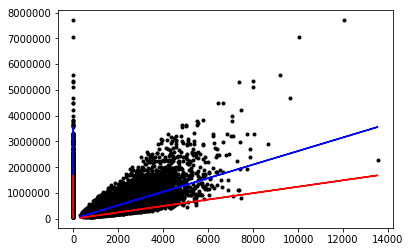

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(simple_feature_matrix,output,'k.',
         simple_feature_matrix,predict_output(simple_feature_matrix, simple_weights_0_penalty),'b-',
        simple_feature_matrix,predict_output(simple_feature_matrix, simple_weights_high_penalty),'r-')

Compute the RSS on the TEST data for the following three sets of weights:
1. The initial weights (all zeros)
2. The weights learned with no regularization
3. The weights learned with high regularization

Which weights perform best?

In [ ]:
initial_predictions = predict_output(simple_test_feature_matrix, initial_weights)
initial_residuals = test_output - initial_predictions
initial_RSS = (initial_residuals **2).sum()
print initial_RSS

1784273282524564.0


In [ ]:
no_regularization_predictions = predict_output(simple_test_feature_matrix, simple_weights_0_penalty)
no_regularization_residuals = test_output - no_regularization_predictions
no_regularization_RSS = (no_regularization_residuals **2).sum()
print no_regularization_RSS

275723634597546.75


In [ ]:
regularization_predictions = predict_output(simple_test_feature_matrix, simple_weights_high_penalty)
regularization_residuals = test_output - regularization_predictions
regularization_RSS = (regularization_residuals **2).sum()
print regularization_RSS

694642100913950.1


***QUIZ QUESTIONS***

**15.**  What is the value of the coefficient for `sqft_living` that you learned with no regularization, rounded to 1 decimal place?  What about the one with high regularization?

**16.** Comparing the lines you fit with the with no regularization versus high regularization, which one is steeper?

**18.** What are the RSS on the test data for each of the set of weights above (initial, no regularization, high regularization)? 


# Running a multiple regression with L2 penalty

**19.** Let us now consider a model with 2 features: `['sqft_living', 'sqft_living15']`.

First, create Numpy versions of your training and test data with these two features. 

In [ ]:
model_features = ['sqft_living', 'sqft_living15'] # sqft_living15 is the average squarefeet for the nearest 15 neighbors. 
my_output = 'price'
(feature_matrix, output) = get_numpy_data(train_data, model_features, my_output)
(test_feature_matrix, test_output) = get_numpy_data(test_data, model_features, my_output)

We need to re-inialize the weights, since we have one extra parameter. Let us also set the step size and maximum number of iterations.

In [ ]:
initial_weights = np.array([0.0,0.0,0.0])
step_size = 1e-12
max_iterations = 1000

**20.** First, let's consider no regularization.  Set the `l2_penalty` to `0.0` and run your ridge regression algorithm to learn the weights of your model.  Call your weights:

`multiple_weights_0_penalty`

In [ ]:
multiple_weights_0_penalty = ridge_regression_gradient_descent(feature_matrix, output, 
                                                               initial_weights, step_size, 
                                                               0.0, max_iterations)
print multiple_weights_0_penalty

[ -0.35743482 243.0541689   22.41481594]


**21.** Next, let's consider high regularization.  Set the `l2_penalty` to `1e11` and run your ridge regression algorithm to learn the weights of your model.  Call your weights:

`multiple_weights_high_penalty`

In [ ]:
multiple_weights_high_penalty = ridge_regression_gradient_descent(feature_matrix, output, 
                                                               initial_weights, step_size, 
                                                               1e11, max_iterations)
print multiple_weights_high_penalty

[ 6.7429658  91.48927361 78.43658768]


Compute the RSS on the TEST data for the following three sets of weights:
1. The initial weights (all zeros)
2. The weights learned with no regularization
3. The weights learned with high regularization

Which weights perform best?

In [ ]:
initial_predictions = predict_output(test_feature_matrix, initial_weights)
initial_residuals = test_output - initial_predictions
initial_RSS = (initial_residuals **2).sum()
print initial_RSS

1784273282524564.0


In [ ]:
no_regularization_predictions = predict_output(test_feature_matrix, multiple_weights_0_penalty)
no_regularization_residuals = test_output - no_regularization_predictions
no_regularization_RSS = (no_regularization_residuals **2).sum()
print no_regularization_RSS

274067618287245.2


In [ ]:
regularization_predictions = predict_output(test_feature_matrix, multiple_weights_high_penalty)
regularization_residuals = test_output - regularization_predictions
regularization_RSS = (regularization_residuals **2).sum()
print regularization_RSS

500404800579555.56


Predict the house price for the 1st house in the test set using the no regularization and high regularization models. (Remember that python starts indexing from 0.) How far is the prediction from the actual price?  Which weights perform best for the 1st house?

In [ ]:
print no_regularization_predictions[0]
print test_output[0] - no_regularization_predictions[0]

387465.47646474396
-77465.47646474396


In [ ]:
print regularization_predictions[0]
print test_output[0] - regularization_predictions[0]

270453.5303048586
39546.46969514142


***QUIZ QUESTIONS***

**22.** What is the value of the coefficient for `sqft_living` that you learned with no regularization, rounded to 1 decimal place?  What about the one with high regularization?

**24.** What are the RSS on the test data for each of the set of weights above (initial, no regularization, high regularization)? 

**25.**  We make prediction for the first house in the test set using two sets of weights (no regularization vs high regularization). Which weights make better prediction <u>for that particular house</u>?